# Variables

In [1]:
YOUR_NAME = 'sara'

AWS_PROFILE = 'cities'

'''
# List of cities to process
cities = ["Belo Horizonte", "Campinas"]#, "Bogota", "Nairobi", "Bamako", 
        #"Lagos", "Accra", "Abidjan", "Mogadishu", "Cape Town", 
        #"Maputo", "Luanda"]

test_cities = ["Belo Horizonte"]
#cities = test_cities

cities = [city.replace(' ', '_') for city in cities]

search_buffer_files = fs.ls(SEARCH_BUFFER_PATH)

cities 

number_of_cities = len(cities)

print(f'City count: {number_of_cities}')
'''
grid_size = 200


# Setup

In [2]:
%load_ext autoreload

In [3]:
MAIN_PATH = "s3://wri-cities-sandbox/identifyingLandSubdivisions/data"
INPUT_PATH = f'{MAIN_PATH}/input'
CITY_INFO_PATH = f'{INPUT_PATH}/city_info'
EXTENTS_PATH = f'{CITY_INFO_PATH}/extents'
BUILDINGS_PATH = f'{INPUT_PATH}/buildings'
BLOCKS_PATH = f'{INPUT_PATH}/blocks'
ROADS_PATH = f'{INPUT_PATH}/roads'
INTERSECTIONS_PATH = f'{INPUT_PATH}/intersections'
GRIDS_PATH = f'{INPUT_PATH}/city_info/grids'
SEARCH_BUFFER_PATH = f'{INPUT_PATH}/city_info/search_buffers'
OUTPUT_PATH = f'{MAIN_PATH}/output'
OUTPUT_PATH_CSV = f'{OUTPUT_PATH}/csv'
OUTPUT_PATH_RASTER = f'{OUTPUT_PATH}/raster'
OUTPUT_PATH_PNG = f'{OUTPUT_PATH}/png'
OUTPUT_PATH_RAW = f'{OUTPUT_PATH}/raw_results'

In [4]:
# Check s3 connection using AWS_PROFILE=CitiesUserPermissionSet profile 
import boto3

session = boto3.Session(profile_name=AWS_PROFILE)
s3 = session.client('s3')

# export CitiesUserPermissionSet profile to use in the next cells
import os
os.environ['AWS_PROFILE'] = AWS_PROFILE


s3.list_buckets()

{'ResponseMetadata': {'RequestId': 'T3NKR7SV5KE4HBRA',
  'HostId': 'y/wynJwPGQpj8fvx6K8GhG6r3/iOi6NyF126CbVWAej3EQQk+ZleNIAUpdlDHbsafYYZ0PmAhO0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'y/wynJwPGQpj8fvx6K8GhG6r3/iOi6NyF126CbVWAej3EQQk+ZleNIAUpdlDHbsafYYZ0PmAhO0=',
   'x-amz-request-id': 'T3NKR7SV5KE4HBRA',
   'date': 'Sat, 29 Mar 2025 22:48:25 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'aft-sandbox-540362055257',
   'CreationDate': datetime.datetime(2022, 9, 13, 15, 12, 20, tzinfo=tzutc())},
  {'Name': 'amplify-citiesindicatorsapi-dev-10508-deployment',
   'CreationDate': datetime.datetime(2023, 8, 30, 5, 5, 13, tzinfo=tzutc())},
  {'Name': 'cities-dev-sandbox',
   'CreationDate': datetime.datetime(2025, 2, 7, 23, 18, 12, tzinfo=tzutc())},
  {'Name': 'cities-heat',
   'CreationDate': datetime.datetime(2023, 6, 1, 13, 22, 1, tzinfo=tzutc())},
  {'Name': 'era5-bra

In [5]:
import coiled

cluster = coiled.Cluster(
    workspace="wri-cities-data",
    name=f'ils-{YOUR_NAME}',
    region="us-west-2",
    arm=True,
    worker_vm_types="r8g.xlarge",
    spot_policy="spot",
    n_workers=8,
    package_sync_ignore=["pyspark", "pypandoc"]
)
client = cluster.get_client()

print(f"Started a new Dask client on Coiled. Dashboard is available at {client.dashboard_link}")


[2025-03-29 17:48:28,450][INFO    ][coiled] Fetching latest package priorities...
[2025-03-29 17:48:28,452][INFO    ][coiled.package_sync] Resolving your local subdivisions2 Python environment...
[2025-03-29 17:48:29,376][INFO    ][coiled.package_sync] Scanning 444 conda packages...
[2025-03-29 17:48:29,383][INFO    ][coiled.package_sync] Scanning 259 python packages...
[2025-03-29 17:48:30,357][INFO    ][coiled] Running pip check...
[2025-03-29 17:48:31,875][INFO    ][coiled] Validating environment...
[2025-03-29 17:48:34,068][INFO    ][coiled] Creating wheel for ~/Documents/Identifying Land Subdivisions/identifyingLandSubdivisions...
[2025-03-29 17:48:34,310][WARNING ][coiled.package_sync] Package - libopenvino-intel-cpu-plugin, libopenvino-intel-cpu-plugin~=2025.0.0 has no install candidate for Python 3.12 linux-aarch64 on conda-forge
[2025-03-29 17:48:34,311][INFO    ][coiled] Uploading coiled_local_identifyingLandSubdivisions...
[2025-03-29 17:48:35,232][INFO    ][coiled] Requesti

Started a new Dask client on Coiled. Dashboard is available at https://cluster-vlhsx.dask.host/97NprtAy9YNWUOTv/status


# RUN

In [6]:
import s3fs
import fsspec
import traceback

import os


fs = s3fs.S3FileSystem(anon=False)
search_buffer_files = fs.ls(SEARCH_BUFFER_PATH)

cities = [x.split('/')[-1] for x in search_buffer_files]
len(cities)

406

In [7]:
'''
THIS IS PRE-PROCESSING
'''

import dask_geopandas as dgpd
import pandas as pd
from dask import delayed, compute, visualize
import geopandas as gpd
from dask.diagnostics import ProgressBar
from citywide_calculation import get_utm_crs
from metrics_calculation import calculate_minimum_distance_to_roads_option_B
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import polygonize, nearest_points
#from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString, GeometryCollection
from scipy.optimize import fminbound, minimize
from shapely.ops import unary_union, polygonize
import geopandas as gpd
from polylabel import polylabel
from shapely.geometry import mapping
from shapely.geometry import mapping, Point
from polylabel import polylabel


@delayed
def get_epsg(city_name):
    search_buffer = f'{SEARCH_BUFFER_PATH}/{city_name}/{city_name}_search_buffer.geoparquet'
    extent = dgpd.read_parquet(search_buffer)
    geometry = extent.geometry[0].compute()
    epsg = get_utm_crs(geometry)
    print(f'{city_name} EPSG: {epsg}')
    return epsg

def load_dataset(path, epsg=None):
    dataset = dgpd.read_parquet(path, npartitions=4)
    
    # Only assign if the file has no CRS
    if epsg:
        if dataset.crs is None:
            dataset = dataset.set_crs("EPSG:4326")  # assume WGS84 if missing
        dataset = dataset.to_crs(epsg)

    return dataset

In [8]:

def to_geojson_dict(geom):
    """
    Convert a Shapely geometry to a GeoJSON-like dict with lists instead of tuples.
    """
    geojson = mapping(geom)
    def recursive_convert(obj):
        if isinstance(obj, tuple):
            return list(obj)
        elif isinstance(obj, list):
            return [recursive_convert(item) for item in obj]
        elif isinstance(obj, dict):
            return {k: recursive_convert(v) for k, v in obj.items()}
        else:
            return obj
    return recursive_convert(geojson)

def compute_largest_inscribed_circle(geom):
    """
    Compute the largest inscribed circle for a given polygon or multipolygon.

    Parameters:
      geom (shapely.geometry): A Polygon or MultiPolygon.
    
    Returns:
      tuple: (optimal_point, max_radius) where optimal_point is a shapely Point and max_radius is a float.
    """
    if geom is None or geom.is_empty:
        return None, None

    if geom.geom_type == 'Polygon':
        geojson_poly = to_geojson_dict(geom)
        # Pass in the coordinates list instead of the entire dict.
        optimal_coords = polylabel(geojson_poly["coordinates"])
        optimal = Point(optimal_coords)
        radius = geom.boundary.distance(optimal)
        return optimal, radius

    elif geom.geom_type == 'MultiPolygon':
        best_point = None
        best_radius = 0
        for poly in geom.geoms:
            geojson_poly = to_geojson_dict(poly)
            optimal_coords = polylabel(geojson_poly["coordinates"])
            candidate = Point(optimal_coords)
            radius = poly.boundary.distance(candidate)
            if radius > best_radius:
                best_radius = radius
                best_point = candidate
        return best_point, best_radius

    else:
        return None, None

def add_inscribed_circle_info(blocks_gdf):
    """
    Adds two new columns to a blocks GeoDataFrame: 'optimal_point' and 'max_radius'
    which indicate the center and radius of the largest inscribed circle for each block.
    Converts the optimal_point geometries to WKT strings for Parquet compatibility.
    
    Parameters:
      blocks_gdf (GeoDataFrame): A GeoDataFrame with block polygons.
      
    Returns:
      GeoDataFrame: The input GeoDataFrame with two new columns.
    """
    # Apply the computation for each geometry
    results = blocks_gdf.geometry.apply(lambda geom: compute_largest_inscribed_circle(geom))
    
    # Unpack the tuple results into two new columns
    blocks_gdf["optimal_point"] = results.apply(lambda x: x[0])
    blocks_gdf["max_radius"] = results.apply(lambda x: x[1])
    
    # Convert the 'optimal_point' column from Shapely objects to WKT strings
    blocks_gdf["optimal_point"] = blocks_gdf["optimal_point"].apply(
        lambda geom: geom.wkt if geom is not None else None
    )
    
    return blocks_gdf


def get_blocks(roads):
    """
    Create urban blocks from a grid and road network.

    Parameters:
      grid (GeoDataFrame): A GeoDataFrame of grid polygons defining the city extent.
      roads (GeoDataFrame): A GeoDataFrame of road line geometries.
    
    Returns:
      GeoDataFrame: A GeoDataFrame of block polygons.
    """
    # Merge all road geometries into a single geometry
    roads_union = unary_union(roads.geometry)
    
    # Polygonize the road network to generate blocks.
    # The polygonize function returns an iterator of Polygons.
    blocks_polygons = list(polygonize(roads_union))
    
    # Create a GeoDataFrame for blocks
    blocks_gdf = gpd.GeoDataFrame(geometry=blocks_polygons, crs=roads.crs)
    
    # Remove any empty geometries resulting from the intersection.
    blocks_gdf = blocks_gdf[~blocks_gdf.is_empty]
    
    return blocks_gdf

@delayed
def produce_blocks(city_name):
    # Construct file paths for the city
    paths = {
        'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
        'buildings': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}.geoparquet',
        'roads': f'{ROADS_PATH}/{city_name}/{city_name}_OSM_roads.geoparquet',
        'intersections': f'{INTERSECTIONS_PATH}/{city_name}/{city_name}_OSM_intersections.geoparquet'
    }
    
    epsg = get_epsg(city_name)
    
    roads = load_dataset(paths['roads'], epsg=epsg)
    
    blocks = get_blocks(roads.compute())

    # Now add the inscribed circle information.
    blocks = add_inscribed_circle_info(blocks)
    
    # Define the output path for the blocks geoparquet
    path_blocks = f'{BLOCKS_PATH}/{city_name}/{city_name}_blocks_{YOUR_NAME}.geoparquet'

    blocks = blocks.set_crs(epsg.compute())

    # Convert the geometry column to WKT before saving
    #blocks["geometry"] = blocks["geometry"].apply(lambda geom: geom.wkt if geom is not None else None)
    
    # Save the blocks dataset. 
    blocks.to_parquet(path_blocks)
    
    # Optionally, return the output path or any summary info.
    return blocks


import time
'''
start_time = time.time()  

#cities = ['Nairobi','Belo_Horizonte']
cities = ["Belo Horizonte", 'Nairobi'] #"Campinas", "Bogota", "Nairobi", "Bamako", "Lagos", "Accra", "Abidjan", "Cape Town", "Luanda"] #"Maputo","Mogadishu", 
cities = [city.replace(' ', '_') for city in cities]

tasks = [produce_blocks(city) for city in cities]
results = compute(*tasks)

end_time = time.time()  
elapsed_time = end_time - start_time

print(f"Tasks completed in {elapsed_time:.2f} seconds.")'
'''

'\nstart_time = time.time()  \n\n#cities = [\'Nairobi\',\'Belo_Horizonte\']\ncities = ["Belo Horizonte", \'Nairobi\'] #"Campinas", "Bogota", "Nairobi", "Bamako", "Lagos", "Accra", "Abidjan", "Cape Town", "Luanda"] #"Maputo","Mogadishu", \ncities = [city.replace(\' \', \'_\') for city in cities]\n\ntasks = [produce_blocks(city) for city in cities]\nresults = compute(*tasks)\n\nend_time = time.time()  \nelapsed_time = end_time - start_time\n\nprint(f"Tasks completed in {elapsed_time:.2f} seconds.")\'\n'

In [9]:
from scipy.stats import t, sem, entropy
import numpy as np

'''
Auxiliary functions for metric 6
'''

def calculate_standardized_kl_azimuth(buildings_df, bin_width_degrees=5):
    azimuths = buildings_df['azimuth'].to_numpy()
    num_bins = int(90 / bin_width_degrees)
    histogram, _ = np.histogram(azimuths, bins=num_bins, range=(0, 90))
    P = histogram / histogram.sum() if histogram.sum() > 0 else np.ones(num_bins) / num_bins
    Q = np.ones(num_bins) / num_bins
    kl_divergence = entropy(P, Q)
    max_kl_divergence = np.log(num_bins)
    return kl_divergence / max_kl_divergence

def compute_azimuth_partition(df):
    def azimuth(geom):
        if geom is None or geom.is_empty:
            return np.nan
        oriented = geom.minimum_rotated_rectangle
        coords = list(oriented.exterior.coords)
        edge = LineString([coords[0], coords[1]])
        dx, dy = edge.xy[0][1] - edge.xy[0][0], edge.xy[1][1] - edge.xy[1][0]
        angle = np.degrees(np.arctan2(dy, dx)) % 180
        return angle % 90

    df = df.copy()
    df['azimuth'] = df['geometry'].map(azimuth)
    return df

@delayed
def compute_block_kl_metrics(buildings_blocks):
    grouped = buildings_blocks.groupby('block_id')
    kl_data = grouped.apply(lambda g: pd.Series({
        'standardized_kl': calculate_standardized_kl_azimuth(g),
        'n_buildings': len(g),
    })).reset_index()
    return kl_data

def compute_block_grid_weights(blocks, grid):
    """
    Computes the proportional overlap of blocks in each grid cell.
    Returns a Dask DataFrame containing block_id, index_right (grid ID), and area_weight.
    """


    #blocks = blocks.rename_axis(index='block_id').reset_index()
    grid = grid.rename_axis(index='grid_id').reset_index()

    def overlay_partition(blocks_df, grid_df):
        """Computes intersection between blocks and grid."""
        return gpd.overlay(blocks_df, grid_df, how='intersection')

    #meta = blocks._meta.merge(grid._meta, how="outer")

    block_grid_overlap = blocks.map_partitions(overlay_partition, grid)#, meta=meta


    # Step 2: Compute area for each block-grid overlap
    block_grid_overlap = block_grid_overlap.assign(
        overlap_area=block_grid_overlap.map_partitions(lambda df: df.geometry.area, meta=('overlap_area', 'f8'))
    )

    # Step 3: Compute the total area of each grid cell
    grid_areas = grid.assign(grid_area=grid.map_partitions(lambda df: df.geometry.area, meta=('grid_area', 'f8')))


    # Step 4: Merge grid cell areas into block-grid overlap
    block_grid_overlap = block_grid_overlap.merge(grid_areas[['grid_id','grid_area']], left_on='grid_id', right_on='grid_id', how='left')

    # Step 5: Compute area weight as the ratio of overlap to grid cell area
    block_grid_overlap = block_grid_overlap.assign(
        area_weight=block_grid_overlap['overlap_area'] / block_grid_overlap['grid_area']
    )
    block_grid_overlap = block_grid_overlap.map_partitions(
        lambda df: df.assign(
            area_weight=df['area_weight'] / df.groupby(df['grid_id'])['area_weight'].transform('sum')
        ),
        meta=block_grid_overlap._meta  # Preserve original structure
    )

    return block_grid_overlap[['block_id', 'optimal_point', 'max_radius', 'grid_id', 'geometry', 'overlap_area', 'grid_area', 'area_weight']]


def aggregate_m6(kl_df, overlap_df):
    df = overlap_df.merge(kl_df, on='block_id', how='left')
    df = df.dropna(subset=['standardized_kl'])

    # Compute weights
    df['weight'] = df['area_weight'] * df['n_buildings']
    df['weighted_kl'] = df['standardized_kl'] * df['weight']

    # Aggregate directly at the GRID level
    grid_aggregated = df.groupby('grid_id').agg(
        total_weighted_kl=('weighted_kl', 'sum'),
        total_weight=('weight', 'sum')
    )

    # Compute final KL divergence for each grid cell
    grid_aggregated['m6'] = grid_aggregated['total_weighted_kl'] / grid_aggregated['total_weight']

    return grid_aggregated[['m6']]



def building_orientation_metrics(city_name):
    paths = {
        'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
        'blocks': f'{BLOCKS_PATH}/{city_name}/{city_name}_blocks_{YOUR_NAME}.geoparquet',
        'buildings_with_distances': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}_with_distances.geoparquet',
    }

    epsg = get_epsg(city_name).compute()
    grid = load_dataset(paths['grid'], epsg=epsg)
    blocks = load_dataset(paths['blocks'], epsg=epsg)
    buildings = load_dataset(paths['buildings_with_distances'], epsg=epsg)

    if 'geom' in grid.columns:
        grid = grid.drop(columns=['geom'])

    blocks['block_id'] = blocks.index

    meta = buildings._meta.copy()
    meta['azimuth'] = 'f8'
    buildings = buildings.map_partitions(compute_azimuth_partition, meta=meta)

    # Fix `sjoin` issues by computing before
    buildings_blocks = dgpd.sjoin(buildings.compute(), blocks.compute(), predicate='intersects')
    buildings_blocks = buildings_blocks[['block_id', 'geometry', 'azimuth']]

    kl_df = compute_block_kl_metrics(buildings_blocks)

    # Keep `block_grid_overlap` lazy
    block_grid_overlap = compute_block_grid_weights(blocks, grid)

    # Aggregate `m6`
    m6_grid = aggregate_m6(kl_df.compute(), block_grid_overlap.compute())
    grid = grid.merge(m6_grid, left_index=True, right_index=True, how='left')
    grid['m6'] = grid['m6'].fillna(0)


    path = f'{OUTPUT_PATH_RASTER}/{city_name}/{city_name}_{str(grid_size)}m_grid_{YOUR_NAME}_metric_6.geoparquet'
    grid.to_parquet(path)
    return path

In [10]:
import dask_geopandas as dgpd
import pandas as pd
from dask import delayed, compute, visualize
import geopandas as gpd
from dask.diagnostics import ProgressBar
from citywide_calculation import get_utm_crs
from metrics_calculation import calculate_minimum_distance_to_roads_option_B
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import polygonize, nearest_points
#from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString, GeometryCollection
from scipy.optimize import fminbound, minimize
import shapely.wkt

@delayed
def get_epsg(city_name):
    search_buffer = f'{SEARCH_BUFFER_PATH}/{city_name}/{city_name}_search_buffer.geoparquet'
    extent = dgpd.read_parquet(search_buffer)
    geometry = extent.geometry[0].compute()
    epsg = get_utm_crs(geometry)
    print(f'{city_name} EPSG: {epsg}')
    return epsg


def load_dataset(path, epsg=None):
    dataset = dgpd.read_parquet(path, npartitions=4)
    
    # Only assign if the file has no CRS
    if epsg:
        if dataset.crs is None:
            dataset = dataset.set_crs("EPSG:4326")  # assume WGS84 if missing
        dataset = dataset.to_crs(epsg)

    return dataset

@delayed
def block_metrics(city_name, YOUR_NAME, grid_size):
    paths = {
        'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
        'buildings': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}.geoparquet',
        'roads': f'{ROADS_PATH}/{city_name}/{city_name}_OSM_roads.geoparquet',
        'intersections': f'{INTERSECTIONS_PATH}/{city_name}/{city_name}_OSM_intersections.geoparquet',
        'blocks' : f'{BLOCKS_PATH}/{city_name}/{city_name}_blocks_{YOUR_NAME}.geoparquet'
    }
    # Get EPSG (you may still use a delayed get_epsg, but ensure you compute it if necessary)
    epsg = get_epsg(city_name).compute()
    
    grid = load_dataset(paths['grid'], epsg=epsg)
    blocks = load_dataset(paths['blocks'])

    if 'geom' in grid.columns:
        grid = grid.drop(columns='geom')
    if 'geom' in blocks.columns:
        blocks = blocks.drop(columns='geom')

    # Ensure that the active geometry is set correctly
    grid = grid.set_geometry("geometry")
    blocks = blocks.set_geometry("geometry")

    grid = grid.persist()
    blocks = blocks.persist()

    import matplotlib.pyplot as plt

    grid_sample = grid.head()
    blocks_sample = blocks.head()

    ax = grid_sample.plot(edgecolor='black', facecolor='none', figsize=(8, 8))
    blocks_sample.plot(ax=ax, color='red', alpha=0.5)
    plt.show()


    # Perform the spatial join with dask-geopandas GeoDataFrames
    blocks_grid_joined = dgpd.sjoin(blocks, grid, predicate='intersects')
    average_block_maxradius = blocks_grid_joined.groupby('index_right')['max_radius'].mean().astype(float)
    
    grid['m7'] = grid.index.map(average_block_maxradius).fillna(0).astype(float)
    
    path = f'{OUTPUT_PATH_RASTER}/{city_name}/{city_name}_{str(grid_size)}m_grid_{YOUR_NAME}.geoparquet'
    
    # Remove problematic column if present
    if 'geom' in grid.columns:
        grid = grid.drop(columns='geom')
    
    grid.to_parquet(path)
    return path

'''
import time

start_time = time.time()  # Start the timer

#cities = ['Nairobi','Belo_Horizonte']
cities = ["Belo Horizonte", "Campinas", "Bogota", "Nairobi", "Bamako", "Lagos", "Accra", "Abidjan", "Cape Town", "Luanda"] #"Maputo","Mogadishu", 
cities = [city.replace(' ', '_') for city in cities]

tasks = [block_metrics(city,YOUR_NAME,grid_size) for city in cities]
results = compute(*tasks)

end_time = time.time()  # End the timer
elapsed_time = end_time - start_time

results

print(f"Tasks completed in {elapsed_time:.2f} seconds.")'
'''

'\nimport time\n\nstart_time = time.time()  # Start the timer\n\n#cities = [\'Nairobi\',\'Belo_Horizonte\']\ncities = ["Belo Horizonte", "Campinas", "Bogota", "Nairobi", "Bamako", "Lagos", "Accra", "Abidjan", "Cape Town", "Luanda"] #"Maputo","Mogadishu", \ncities = [city.replace(\' \', \'_\') for city in cities]\n\ntasks = [block_metrics(city,YOUR_NAME,grid_size) for city in cities]\nresults = compute(*tasks)\n\nend_time = time.time()  # End the timer\nelapsed_time = end_time - start_time\n\nresults\n\nprint(f"Tasks completed in {elapsed_time:.2f} seconds.")\'\n'

In [11]:
from shapely.geometry import Polygon

def get_internal_buffer_with_target_area(geom, target_area, tolerance=1e-6, max_iter=100):
    """
    Iteratively finds an internal buffer that results in the target area.

    Parameters:
    - geom: Shapely Polygon geometry.
    - target_area: Desired area for the internal buffer.
    - tolerance: Error tolerance for area difference.
    - max_iter: Maximum iterations to refine buffer.

    Returns:
    - Buffered geometry (Polygon) or the original geometry if buffering is not possible.
    """
    if geom.is_empty or geom.area <= target_area:
        return geom  # Return original if no valid buffer can be made

    buffer_dist = -0.1 * (geom.area ** 0.5)  # Start with a fraction of block size
    iteration = 0

    while iteration < max_iter:
        buffered_geom = geom.buffer(buffer_dist)

        if buffered_geom.is_empty:
            return geom  # If buffering fails, return original geometry

        new_area = buffered_geom.area
        area_diff = abs(new_area - target_area)

        if area_diff < tolerance:
            return buffered_geom  # Found a good enough buffer

        # Adjust buffer distance using a binary search-like approach
        if new_area > target_area:
            buffer_dist *= 1.1  # Increase buffer distance
        else:
            buffer_dist *= 0.9  # Decrease buffer distance

        iteration += 1

    return buffered_geom  # Return best-found buffer






@delayed
def compute_m6_m7_m8(city_name, YOUR_NAME, grid_size, epsilon=0.01):
    """
    Computes:
    - M6: KL divergence (building orientation)
    - M7: Average block width
    - M8: Building density ratio (inner vs. outer buffer)
    """

    paths = {
        'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
        'blocks': f'{BLOCKS_PATH}/{city_name}/{city_name}_blocks_{YOUR_NAME}.geoparquet',
        'buildings_with_distances': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}_with_distances.geoparquet',
    }

    epsg = get_epsg(city_name).compute()
    grid = load_dataset(paths['grid'], epsg=epsg)
    blocks = load_dataset(paths['blocks'], epsg=epsg)
    buildings = load_dataset(paths['buildings_with_distances'], epsg=epsg)

    if 'geom' in grid.columns:
        grid = grid.drop(columns=['geom'])

    blocks['block_id'] = blocks.index

    # Compute M8: Building Density in Buffers
    blocks['epsilon_buffer'] = blocks['geometry'].buffer(-epsilon * blocks['max_radius'])
    blocks['width_buffer'] = blocks['geometry'].buffer(-0.5 * blocks['max_radius'])

    '''
    # Compute M6: KL divergence (Building Orientation)
    meta = buildings._meta.copy()
    meta['azimuth'] = 'f8'
    buildings = buildings.map_partitions(compute_azimuth_partition, meta=meta)
    '''
    buildings_blocks = dgpd.sjoin(buildings.compute(), blocks.compute(), predicate='intersects')
    buildings_blocks = buildings_blocks[['block_id', 'geometry', 'azimuth']]
    '''
    kl_df = compute_block_kl_metrics(buildings_blocks)
    '''
    block_grid_overlap = compute_block_grid_weights(blocks, grid)
    block_grid_overlap = block_grid_overlap.compute()

    '''
    m6_grid = aggregate_m6(kl_df.compute(), block_grid_overlap)
 
    # Compute M7: Block Width
    block_grid_overlap['weighted_max_radius'] = (
        block_grid_overlap['max_radius'] * block_grid_overlap['area_weight']
    )

    grid_m7 = block_grid_overlap.groupby('grid_id').agg(
        total_weighted_max_radius=('weighted_max_radius', 'sum'),
        total_weight=('area_weight', 'sum')
    )
    grid_m7['m7'] = grid_m7['total_weighted_max_radius'] / grid_m7['total_weight']

    '''

    blocks['A'] = blocks.map_partitions(compute_building_to_buffer_ratio, buildings_blocks, 'epsilon_buffer', meta=('A', 'f8'))
    blocks['B'] = blocks.map_partitions(compute_building_to_buffer_ratio, buildings_blocks, 'width_buffer', meta=('B', 'f8'))


    blocks['m8'] = (blocks['A'] / blocks['B']).fillna(0)

    # Then proceed with the multiplication
    block_grid_overlap['weighted_m8'] = block_grid_overlap['area_weight'] * blocks.set_index('block_id')['m8']


    grid_m8 = block_grid_overlap.groupby('grid_id').agg(
        total_weighted_m8=('weighted_m8', 'sum'),
        total_weight=('area_weight', 'sum')
    )
    grid_m8['m8'] = grid_m8['total_weighted_m8'] / grid_m8['total_weight']
    '''
    # Merge all metrics
    grid = grid.merge(m6_grid, left_index=True, right_index=True, how='left')
    grid = grid.merge(grid_m7[['m7']], left_index=True, right_index=True, how='left')'
    '''
    #grid = grid.merge(grid_m8[['m8']], left_index=True, right_index=True, how='left')

    # Fill NaNs
    '''
    grid['m6'] = grid['m6'].fillna(0)
    grid['m7'] = grid['m7'].fillna(0)'
    '''
    grid['m8'] = grid['m8'].fillna(0)

    # Save Output
    grid = grid.compute()  
    path = f'{OUTPUT_PATH_RASTER}/{city_name}/{city_name}_{str(grid_size)}m_grid_{YOUR_NAME}_metrics_6_7_8.geoparquet'
    grid.to_parquet(path)

    return path


'''
import time
from dask import compute

start_time = time.time()  # Start the timer

cities = ['Nairobi']
cities = [city.replace(' ', '_') for city in cities]

tasks = [compute_m6_m7_m8(city, YOUR_NAME, grid_size) for city in cities]
results = compute(*tasks)  

end_time = time.time()  # End the timer
elapsed_time = end_time - start_time

print(f"Tasks completed in {elapsed_time:.2f} seconds.")'
'''



'\nimport time\nfrom dask import compute\n\nstart_time = time.time()  # Start the timer\n\ncities = [\'Nairobi\']\ncities = [city.replace(\' \', \'_\') for city in cities]\n\ntasks = [compute_m6_m7_m8(city, YOUR_NAME, grid_size) for city in cities]\nresults = compute(*tasks)  \n\nend_time = time.time()  # End the timer\nelapsed_time = end_time - start_time\n\nprint(f"Tasks completed in {elapsed_time:.2f} seconds.")\'\n'

In [14]:
import numpy as np
import dask_geopandas as dgpd
import dask.dataframe as dd

import numpy as np
import dask_geopandas as dgpd

import numpy as np
import dask_geopandas as dgpd

def compute_building_to_buffer_ratio(partition, buildings_blocks, buffer_col):
    """Computes building-to-buffer area ratio, ensuring block-by-block clipping, in a fully parallelized manner."""

    if len(partition) == 0:
        return dd.Series(index=partition.index, dtype='float64')

    # Ensure buffer_gdf is structured correctly
    buffer_gdf = partition[['block_id', buffer_col]].set_geometry(buffer_col)

    # Restrict buildings to only relevant blocks (per partition)
    relevant_buildings = buildings_blocks[buildings_blocks['block_id'].isin(partition['block_id'].unique())]

    # **Align buildings with their corresponding buffer in a one-to-one manner**
    relevant_buildings = relevant_buildings.merge(buffer_gdf[['block_id', buffer_col]], on='block_id', how='inner')

    # **Correct way to perform block-wise clipping**
    clipped_geometries = relevant_buildings.apply(
        lambda row: row['geometry'].intersection(row[buffer_col]) if row[buffer_col] is not None else row['geometry'],
        axis=1
    )

    # Store clipped buildings
    relevant_buildings['clipped_building'] = clipped_geometries

    # Compute total building area inside buffer per block
    relevant_buildings['building_area'] = relevant_buildings['clipped_building'].area
    total_building_area = relevant_buildings.groupby('block_id')['building_area'].sum()

    # Compute buffer area
    buffer_area = buffer_gdf.set_index('block_id').geometry.area

    # Align indices to ensure safe division
    total_building_area, buffer_area = total_building_area.align(buffer_area, fill_value=0)

    # Compute final ratio safely
    ratio = (total_building_area / buffer_area).fillna(0)

    return ratio


city_name = 'Nairobi'
epsilon = 0.1
paths = {
    'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
    'blocks': f'{BLOCKS_PATH}/{city_name}/{city_name}_blocks_{YOUR_NAME}.geoparquet',
    'buildings_with_distances': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}_with_distances.geoparquet',
}

epsg = get_epsg(city_name).compute()
grid = load_dataset(paths['grid'], epsg=epsg)
blocks = load_dataset(paths['blocks'], epsg=epsg)
buildings = load_dataset(paths['buildings_with_distances'], epsg=epsg)

if 'geom' in grid.columns:
    grid = grid.drop(columns=['geom'])

blocks['block_id'] = blocks.index

# Compute M8: Building Density in Buffers
blocks['epsilon_buffer'] = blocks['geometry'].buffer(-(1.-epsilon) * blocks['max_radius'])
blocks['width_buffer'] = blocks['geometry'].buffer(-0.5 * blocks['max_radius'])


buildings_blocks = dgpd.sjoin(buildings.compute(), blocks.compute(), predicate='intersects')
buildings_blocks = buildings_blocks[['block_id', 'geometry','epsilon_buffer','width_buffer']]#, 'azimuth']]
buildings_blocks_df = buildings_blocks.compute()


'''
# Compute M6: KL divergence (Building Orientation)
meta = buildings._meta.copy()
meta['azimuth'] = 'f8'
buildings = buildings.map_partitions(compute_azimuth_partition, meta=meta)

buildings_blocks = dgpd.sjoin(buildings.compute(), blocks.compute(), predicate='intersects')
buildings_blocks = buildings_blocks[['block_id', 'geometry']]#, 'azimuth']]

# Compute M8 using parallelized approach
blocks['A'] = blocks.map_partitions(compute_building_to_buffer_ratio, buildings_blocks, 'epsilon_buffer', meta=('A', 'f8'))
blocks['B'] = blocks.map_partitions(compute_building_to_buffer_ratio, buildings_blocks, 'width_buffer', meta=('B', 'f8'))

# Compute M8 as A / B
blocks['m8'] = (blocks['A'] / blocks['B']).fillna(0)
blocks_df = blocks.compute()
'''
'''

block_grid_overlap = compute_block_grid_weights(blocks, grid)
block_grid_overlap = block_grid_overlap.compute()
'''
#blocks_df = blocks.compute()


/Users/sarangof/miniconda3/envs/subdivisions2/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 357.19 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


'\n\nblock_grid_overlap = compute_block_grid_weights(blocks, grid)\nblock_grid_overlap = block_grid_overlap.compute()\n'

In [17]:
buildings_blocks_df

,block_id,geometry,epsilon_buffer,width_buffer
id,,,,
08b7a45948200fff0200c23c3e3bc473,13907,"POLYGON ((282422.947 9881024.113, 282421.607 9...","POLYGON ((282124.452 9880827.306, 282127.019 9...","POLYGON ((282006.421 9880829.795, 282007.392 9..."
08b7a45948204fff02000b682fd97adb,13907,"POLYGON ((282470.257 9880990.949, 282455.208 9...","POLYGON ((282124.452 9880827.306, 282127.019 9...","POLYGON ((282006.421 9880829.795, 282007.392 9..."
08b7a45948204fff02002fc8a9d425fd,13907,"POLYGON ((282451.599 9881004.363, 282429.975 9...","POLYGON ((282124.452 9880827.306, 282127.019 9...","POLYGON ((282006.421 9880829.795, 282007.392 9..."
08b7a45948204fff020031df56216a5e,13907,"POLYGON ((282461.342 9880980.268, 282454.834 9...","POLYGON ((282124.452 9880827.306, 282127.019 9...","POLYGON ((282006.421 9880829.795, 282007.392 9..."
08b7a45948204fff0200f65f80e10e45,13907,"POLYGON ((282461.342 9880980.268, 282424.984 9...","POLYGON ((282124.452 9880827.306, 282127.019 9...","POLYGON ((282006.421 9880829.795, 282007.392 9..."
...,...,...,...,...
08b7a6ecf6babfff0200f40f85b247f6,19941,"POLYGON ((270253.554 9830254.263, 270253.171 9...","POLYGON ((270068.167 9830166.559, 270065.943 9...","POLYGON ((270055.332 9830144.542, 270044.269 9..."
08b7a6ecf6bb0fff020092fb3f5afa1f,13554,"POLYGON ((270523.467 9830260.228, 270512.563 9...","POLYGON ((270849.832 9830807.843, 270827.465 9...","POLYGON ((270551.589 9831013.09, 270552.864 98..."
08b7a6ecf6bb1fff0200c119d0a97af7,13554,"POLYGON ((270441.468 9830258.934, 270435.345 9...","POLYGON ((270849.832 9830807.843, 270827.465 9...","POLYGON ((270551.589 9831013.09, 270552.864 98..."


In [ ]:
buffers = buildings_blocks_df.groupby('block_id')['width_buffer'].transform('first')

In [ ]:
buildings_blocks_df['clipped_geometry'] = buildings_blocks_df.geometry.clip(buffers)

/Users/sarangof/miniconda3/envs/subdivisions2/lib/python3.12/site-packages/geopandas/geoseries.py:1520: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32737
Right CRS: None

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type, sort=sort)


In [19]:
buildings_blocks_df = buildings_blocks.compute()

/Users/sarangof/miniconda3/envs/subdivisions2/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 357.20 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [101]:
total_building_area_df.loc[[2,5,3,4]]

KeyError: '[3, 4] not in index'

<Axes: >

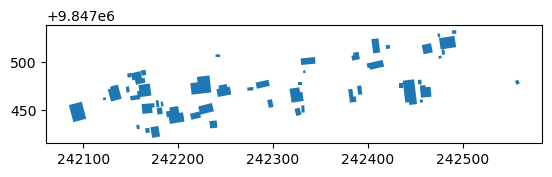

In [60]:
buildings_within_df[buildings_within_df.block_id_right==11591].plot()

In [30]:
buffer_col = 'width_buffer'
buffer_gdf = partition[['block_id', buffer_col]].copy().set_geometry(buffer_col)
relevant_buildings = buildings_blocks_df[buildings_blocks_df['block_id'].isin(partition['block_id'].unique())]
buildings_within = dgpd.sjoin(relevant_buildings, buffer_gdf, predicate='within')

In [32]:
buildings_within_df = buildings_within.compute()

<Axes: >

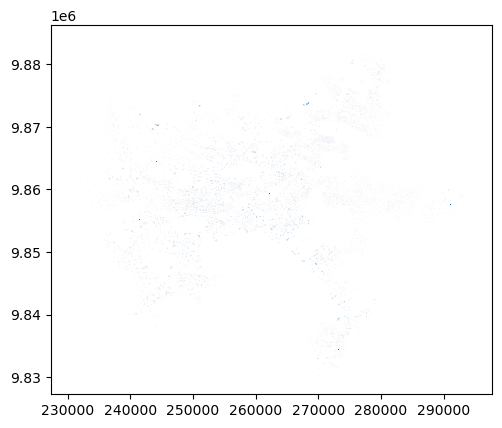

In [34]:
buildings_within_df.plot()

In [ ]:
# Filter `buildings_blocks` to only include relevant blocks in this partition


# Perform spatial join on **only relevant buildings**


In [21]:
buildings_within_df

,block_id_left,geometry,index_right,block_id_right
id,,,,
08b7a6e402c70fff0200f1ccdc0ee74e,535,"POLYGON ((264356.218 9865897.932, 264351.595 9...",535,535
08b7a6e419471fff02002171ee669339,6139,"POLYGON ((259089.195 9871486.266, 259088.7 987...",6139,6139
08b7a6e45da41fff0200cb6b048b45f4,9020,"POLYGON ((240658.646 9868953.641, 240655.499 9...",9020,9020
08b7a6e501080fff02002d0eaf187e35,3190,"POLYGON ((268686.16 9848849.139, 268684.606 98...",3190,3190
08b7a6e50b2e0fff020067a51efda6d9,1261,"POLYGON ((262379.48 9853716.42, 262380.004 985...",1261,1261
08b7a6e50e6a6fff02003c5bcdc2a0c2,2026,"POLYGON ((267363.31 9851920.511, 267362.521 98...",2026,2026


In [20]:
client.close()